# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [23]:
import io
import os
import numpy as np
import scipy
import scipy.linalg as slg
import pandas
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [24]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [25]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = {w: i for i, w in enumerate(self.word2vec.keys())}
        self.id2word = {i: w for w, i in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                self.word2vec[word] /= np.linalg.norm(self.word2vec[word])
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        value_w = self.embeddings[self.word2id[w]]
        sorted_score = np.argsort(self.embeddings.dot(value_w))[::-1]        
        return [self.id2word[i] for i in sorted_score[1:K+1]]

    def score(self, w1, w2):
        value_w1 = self.embeddings[self.word2id[w1]]
        value_w2 = self.embeddings[self.word2id[w2]]
        return value_w1.T.dot(value_w2)


In [26]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'Paris', 'Germany'), ('dog', 'pet', 'cats', 'France', 'Berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(w2v.most_similar(w1))

Loaded 25000 pretrained word vectors
cat dog 0.671683666279
dog pet 0.684206402967
dogs cats 0.707438932805
Paris France 0.705859545241
Germany Berlin 0.706025301534
['cats', 'kitty', 'kitten', 'Cat', 'dog']
['dogs', 'puppy', 'Dog', 'canine', 'pup']
['dog', 'Dogs', 'puppies', 'cats', 'canine']
['Parisian', 'France', 'Versailles', 'Lyon', 'Bordeaux']
['Austria', 'Bavaria', 'Berlin', 'Munich', 'German']


In [27]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                mean = np.mean(np.array([w2v.embeddings[w2v.word2id[w]] for w in sent if w in self.w2v.word2vec]), 
                               axis=0)
            else:
                # idf-weighted mean of word vectors
                mean = np.mean(np.array([idf[w] * w2v.embeddings[w2v.word2id[w]] for w in sent 
                                         if w in self.w2v.word2vec]),
                               axis=0)
            sentemb.append(mean / np.linalg.norm(mean))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)[0]
        
        scores = np.dot(keys, query)
        sorted_score_idx = np.argsort(scores)[::-1]
        
        closest_sentences = []
        for i in range(K):
            closest_sentences.append(sentences[sorted_score_idx[i+1]])
        
        return closest_sentences

    def score(self, s1, s2, idf=False):
        # vectors are already normalized
        vecs = self.encode([s1, s2], idf)
        score = vecs[0].T.dot(vecs[1])
        
        print("Score: ", score)
        return score
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
                idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        return idf

In [28]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'))
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open(os.path.join(PATH_TO_DATA, 'sentences.txt'), 'r') as f:
    sentences = [s.split() for s in f.readlines()]
    
# You will be evaluated on the output of the following:
closest_mean = s2v.most_similar(sentences[10], sentences, idf=False)  # BoV-mean
print("Closest sentences from \"{}\" are {}".format(' '.join(sentences[10]), [' '.join(s) for s in closest_mean]))
s2v.score(sentences[7], sentences[13], idf=False)

# Build idf scores for each word
idf = s2v.build_idf(sentences)
closest_idf = s2v.most_similar(sentences[10], sentences, idf=idf)  # BoV-mean-idf
print("Closest sentences from \"{}\" are {}".format(' '.join(sentences[10]), [' '.join(s) for s in closest_idf]))
s2v.score(sentences[7], sentences[13], idf=idf)

Loaded 100000 pretrained word vectors
Closest sentences from "1 smiling african american boy ." are ['an african american man smiling .', 'a little african american boy and girl looking up .', 'a girl in black hat holding an african american baby .', 'an afican american woman standing behind two small african american children .', 'african american woman putting braids in an adorable asian girls hair .']
Score:  0.622450337033
Closest sentences from "1 smiling african american boy ." are ['an african american man smiling .', 'a little african american boy and girl looking up .', 'a girl in black hat holding an african american baby .', 'an afican american woman standing behind two small african american children .', 'african american woman putting braids in an adorable asian girls hair .']
Score:  0.62245269111


0.62245269111018731

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [29]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

wv_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)
wv_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [30]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)
v = sorted(wv_fr.word2vec.keys() & wv_en.word2vec.keys())

X = np.vstack([wv_fr.embeddings[wv_fr.word2id[w]] for w in v]).T

Y = np.vstack([wv_en.embeddings[wv_en.word2id[w]] for w in v]).T

In [31]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

U, S, Vt = slg.svd(Y.dot(X.T))

W = U.dot(Vt)

In [32]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

def nearest_neighbors_multilingual(input_wv, gt_output_wv, W, w, K = 7):

    output_wv = np.dot(W, input_wv.embeddings[input_wv.word2id[w]])
    scores = np.dot(gt_output_wv.embeddings, output_wv)
    sorted_scores = np.argsort(scores)[::-1]

    return [gt_output_wv.id2word[i] for i in sorted_scores[:K]]

for word_fr,word_en in zip(['chat', 'cheval', 'soleil', 'poisson'], ['cat', 'horse', 'sun', 'fish']):
    print(word_fr + ':')
    print(nearest_neighbors_multilingual(wv_fr, wv_en, W, word_fr))
    print(word_en + ':')
    print(nearest_neighbors_multilingual(wv_en, wv_fr, W.T, word_en))
    print('###############################')

chat:
['cat', 'rabbit', 'feline', 'poodle', 'hamster', 'kittens', 'dog']
cat:
['cat', 'chat', 'dog', 'chats', 'chatte', 'chien', 'grizzly']
###############################
cheval:
['horse', 'horses', 'cheval', 'horseman', 'dressage', 'hooves', 'horseback']
horse:
['horse', 'cheval', 'horses', 'galop', 'chevaux', 'attelage', 'attelé']
###############################
soleil:
['sun', 'ecliptic', 'perihelion', 'soleil', 'solstice', 'luminosity', 'brightness']
sun:
['sun', 'soleil', 'moon', 'lune', 'astre', 'soleils', 'saturne']
###############################
poisson:
['mackerel', 'fish', 'shrimp', 'lobster', 'eel', 'prawn', 'shark']
fish:
['poissons', 'fish', 'crevettes', 'crustacés', 'truites', 'poisson', 'escargots']
###############################


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [7]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_sst(filename, given_labels=True):
    X, y = [], []
    with open(filename, 'r') as file:
        for row in file.readlines():
            if given_labels:
                label, sentence = row.split(' ', 1)
                y.append(int(label))
            else:
                sentence = row
            X.append(sentence.split())
    if not given_labels:
        return X
    return X,y

X_train, y_train = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.train'))
X_dev, y_dev = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.dev'))
X_test = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.test.X'), given_labels=False)


In [8]:
# 2 - Encode sentences with the BoV model above
X_train_avg = s2v.encode(X_train)
X_dev_avg = s2v.encode(X_dev)
X_test_avg = s2v.encode(X_test)

X_train_idf = s2v.encode(X_train, idf=s2v.build_idf(X_train))
X_dev_idf = s2v.encode(X_dev, idf=s2v.build_idf(X_dev))
X_test_idf = s2v.encode(X_test, idf=s2v.build_idf(X_test))

In [9]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
lbd = 0.003

### Mean Average ###
model_avg = LogisticRegressionCV(Cs=int(1./lbd), cv=3, random_state=42, multi_class='multinomial', solver='lbfgs', max_iter=500)
model_avg.fit(X_train_avg, y_train)

print("Score train: ", model_avg.score(X_train_avg, y_train))
print("Score dev: ", model_avg.score(X_dev_avg, y_dev))

### Weighted Average ###
model_weighted = LogisticRegressionCV(Cs=int(1./lbd), cv=3, random_state=42, multi_class='multinomial', solver='lbfgs', max_iter=500)
model_weighted.fit(X_train_idf, y_train)

print("Score train: ", model_weighted.score(X_train_idf, y_train))
print("Score dev: ", model_weighted.score(X_dev_idf, y_dev))

Score train:  0.498127340824
Score dev:  0.437783832879
Score train:  0.493328651685
Score dev:  0.435059037239


In [10]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# Writing the output predictions for test dataset
predictions = model_avg.predict(X_test_avg)
with open('logreg_bov_y_test_sst.txt', 'w') as f:
    for i in range(len(predictions)):
        f.write(str(predictions[i]))
        if i != len(predictions)-1:
            f.write('\n')

In [11]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

improved_model = SVC(C = 300)

improved_model.fit(X_train_avg, y_train)


# Validation dataset
dev_predictions = improved_model.predict(X_dev_avg)
print("accuracy: ", improved_model.score(X_dev_avg, y_dev))

improved_predictions = improved_model.predict(X_test_avg)

with open('XXX_bov_y_test_sst.txt', 'w') as f:
    for i in range(len(improved_predictions)):
        f.write(str(improved_predictions[i]))
        if i != len(improved_predictions)-1:
            f.write('\n')

accuracy:  0.425068119891


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [13]:
import keras

In [14]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"

def load_sst(filename, given_labels=True):
    X, y = [], []
    with open(filename, 'r') as file:
        for row in file.readlines():
            if given_labels:
                label, sentence = row.split(' ', 1)
                y.append(int(label))
            else:
                sentence = row
            X.append(sentence.strip())
    if not given_labels:
        return X
    return X,y

X_train, y_train = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.train'))
X_dev, y_dev = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.dev'))
X_test = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.test.X'), given_labels=False)

In [15]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

n = 5000
Xp_train = [keras.preprocessing.text.one_hot(s, n) for s in X_train]
Xp_dev = [keras.preprocessing.text.one_hot(s, n) for s in X_dev]
Xp_test = [keras.preprocessing.text.one_hot(s, n) for s in X_test]


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [16]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

Xp_train = keras.preprocessing.sequence.pad_sequences(Xp_train)
Xp_dev = keras.preprocessing.sequence.pad_sequences(Xp_dev)
Xp_test = keras.preprocessing.sequence.pad_sequences(Xp_test)

## 4.2 - Design and train your model

In [17]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = n  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))


In [18]:
# 5 - Define your loss/optimizer/metrics


loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 185,157
Trainable params: 185,157
Non-trainable params: 0
_________________________________________________________________
None


/home/amine/miniconda3/lib/python3.5/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 124s - loss: 0.8745 - acc: 0.6608 - val_loss: 1.7433 - val_acc: 0.3333
Epoch 2/5
 - 123s - loss: 0.7042 - acc: 0.7362 - val_loss: 2.0240 - val_acc: 0.3451
Epoch 3/5
 - 113s - loss: 0.5965 - acc: 0.7773 - val_loss: 2.1668 - val_acc: 0.3497
Epoch 4/5
 - 136s - loss: 0.5370 - acc: 0.8010 - val_loss: 2.3868 - val_acc: 0.3515
Epoch 5/5
 - 118s - loss: 0.4720 - acc: 0.8277 - val_loss: 2.4786 - val_acc: 0.3497
Training Accuracy: 0.9170
Testing Accuracy:  0.3497


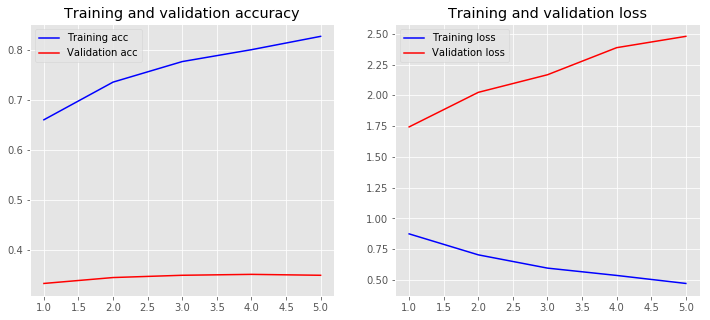

In [60]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

bs = 8
n_epochs = 5

yp_train = keras.utils.to_categorical(y_train, num_classes=n_classes)
yp_dev = keras.utils.to_categorical(y_dev, num_classes=n_classes)

history = model.fit(Xp_train, yp_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(Xp_dev, yp_dev), verbose=2)

loss, accuracy = model.evaluate(Xp_train, yp_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Xp_dev, yp_dev, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [62]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

predictions = model.predict(Xp_test)

with open('logreg_lstm_y_test_sst.txt', 'w') as f:
    for i in range(len(predictions)):
        f.write(str(np.argmax(predictions[i])))
        if i != len(improved_predictions)-1:
            f.write('\n')

## 4.3 -- innovate !

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 64)          134464    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
__________

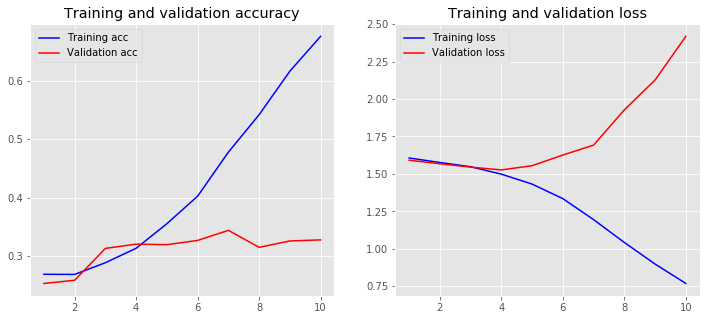

In [33]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.
import matplotlib.pyplot as plt
import keras.layers as layers
plt.style.use('ggplot')

from keras.models import Sequential
from keras import regularizers

embed_dim  = 300  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
n_classes  = 5
embedding_dim = 100
vocab_size = n  # size of the vocabulary

model = Sequential()

model.add(layers.Embedding(n, embed_dim, trainable=False))
model.add(layers.Conv1D(64, 7, activation='relu', padding='same'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 7, activation='relu', padding='same'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(10e-4)))
model.add(layers.Dense(n_classes, activation='sigmoid'))  #multi-label (k-hot encoding)


loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

bs = 64
n_epochs = 10

yp_train = keras.utils.to_categorical(y_train, num_classes=n_classes)
yp_dev = keras.utils.to_categorical(y_dev, num_classes=n_classes)

history = model.fit(Xp_train, yp_train,
                    epochs=n_epochs,
                    verbose=2,
                    validation_data=(Xp_dev, yp_dev),
                    batch_size=bs)
loss, accuracy = model.evaluate(Xp_train, yp_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Xp_dev, yp_dev, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

predictions = model.predict(Xp_test)

with open('XXX_XXX_y_test_sst.txt', 'w') as f:
    for i in range(len(predictions)):
        f.write(str(np.argmax(predictions[i])))
        if i != len(predictions)-1:
            f.write('\n')